In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Sentetik veri oluşturma
np.random.seed(42)  # Tekrarlanabilirlik için seed ayarı

# Örnek veri boyutu
n_samples = 1000

# Sensör verileri (sıcaklık, titreşim, basınç)
temperature = np.random.normal(50, 10, n_samples)  # Ortalama 50, standart sapma 10
vibration = np.random.normal(5, 2, n_samples)      # Ortalama 5, standart sapma 2
pressure = np.random.normal(100, 20, n_samples)    # Ortalama 100, standart sapma 20

# Arıza durumu (0: Normal, 1: Arıza)
failure = ((temperature > 60) | (vibration > 8) | (pressure > 130)).astype(int)

# Veriyi bir DataFrame'e dönüştürme
data = pd.DataFrame({
    "temperature": temperature,
    "vibration": vibration,
    "pressure": pressure,
    "failure": failure
})

# Veriyi göster
data.head()

,temperature,vibration,pressure,failure
0,54.967142,7.798711,86.496435,0
1,48.617357,6.849267,97.109627,0
2,56.476885,5.119261,84.151602,0
3,65.230299,3.706126,93.840769,1
4,47.658466,6.396447,62.127707,0


In [7]:
# Veri hakkında temel bilgiler
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  1000 non-null   float64
 1   vibration    1000 non-null   float64
 2   pressure     1000 non-null   float64
 3   failure      1000 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 31.4 KB


,temperature,vibration,pressure,failure
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,50.193321,5.141672,100.116684,0.270000
std,9.792159,1.994909,19.669086,0.444182
min,17.587327,-0.880777,39.609757,0.000000
25%,43.524097,3.787517,87.040008,0.000000
50%,50.253006,5.126154,99.994985,0.000000
75%,56.479439,6.457764,113.218306,1.000000
max,88.527315,11.386215,178.524754,1.000000


In [8]:
# Arıza durumlarının dağılımı
data["failure"].value_counts()

failure
0    730
1    270
Name: count, dtype: int64

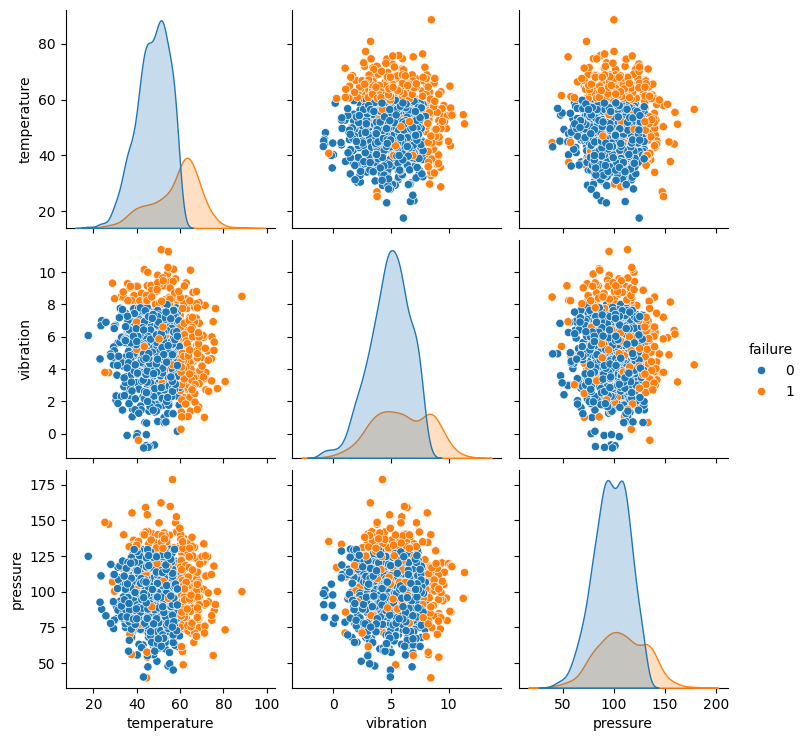

In [9]:
# Sensör verilerinin dağılımını görselleştirme
sns.pairplot(data, hue="failure")
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Özellikler ve hedef değişken
X = data.drop("failure", axis=1)  # Sensör verileri
y = data["failure"]               # Arıza durumu

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Veri normalizasyonu
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Model oluşturma ve eğitme
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Tahmin yapma
y_pred = model.predict(X_test)

# Model değerlendirme
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       149
           1       1.00      1.00      1.00        51

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [13]:
import joblib

# Modeli kaydetme
joblib.dump(model, "predictive_maintenance_model.pkl")

['predictive_maintenance_model.pkl']

In [14]:
from sklearn.model_selection import GridSearchCV

# Hiperparametre aralıkları
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# En iyi parametreler
print("En iyi parametreler:", grid_search.best_params_)

# En iyi model
best_model = grid_search.best_estimator_

# Test seti üzerinde değerlendirme
y_pred = best_model.predict(X_test)
print("Optimize edilmiş model doğruluk:", accuracy_score(y_test, y_pred))

En iyi parametreler: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Optimize edilmiş model doğruluk: 1.0


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

# LSTM modeli
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_lstm, _ = self.lstm(x)
        out = self.fc(h_lstm[:, -1, :])
        return torch.sigmoid(out)

# Model, kayıp fonksiyonu ve optimizasyon
input_size = 3  # Özellik sayısı (sıcaklık, titreşim, basınç)
hidden_size = 50
output_size = 1  # Çıktı (arıza durumu: 0 veya 1)

model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Veriyi PyTorch tensor'larına dönüştürme
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Model eğitimi
epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Model değerlendirme
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred = (y_pred > 0.5).float()
    accuracy = (y_pred == y_test_tensor).float().mean()
    print("Test Doğruluk:", accuracy.item())

Epoch 1/10, Loss: 0.6714590191841125
Epoch 2/10, Loss: 0.6701807975769043
Epoch 3/10, Loss: 0.6689062714576721
Epoch 4/10, Loss: 0.667635440826416
Epoch 5/10, Loss: 0.6663681864738464
Epoch 6/10, Loss: 0.66510409116745
Epoch 7/10, Loss: 0.6638430953025818
Epoch 8/10, Loss: 0.6625843644142151
Epoch 9/10, Loss: 0.6613278388977051
Epoch 10/10, Loss: 0.6600725054740906
Test Doğruluk: 0.7450000047683716


In [22]:
# Modeli değerlendirme moduna al
model.eval()

# Test verisi üzerinde tahmin yap
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred = (y_pred > 0.5).float()  # 0.5 eşik değeri ile sınıflandır
    accuracy = (y_pred == y_test_tensor).float().mean()
    print("Test Doğruluk:", accuracy.item())

Test Doğruluk: 0.7450000047683716


In [23]:
# Modeli kaydet
torch.save(model.state_dict(), "lstm_model.pth")

# Modeli yükle (örnek)
# model = LSTMModel(input_size, hidden_size, output_size)
# model.load_state_dict(torch.load("lstm_model.pth"))

In [25]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np

# Örnek veri oluşturma
X = np.random.rand(1000, 10, 3)  # 1000 örnek, 10 zaman adımı, 3 özellik
y = np.random.randint(0, 2, (1000, 1))  # İkili sınıflandırma için etiketler

# Veriyi eğitim ve test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# PyTorch tensörlerine çevirme
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# LSTM Modeli Tanımlama
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()  # Sigmoid aktivasyonu

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Son zaman adımını al
        return self.sigmoid(out)

# Optuna amaç fonksiyonu
def objective(trial):
    # Hiperparametre aralıkları
    hidden_size = trial.suggest_int("hidden_size", 32, 128)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    # Modeli oluştur
    model = LSTMModel(input_size=3, hidden_size=hidden_size, output_size=1, num_layers=num_layers, dropout=dropout)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Model eğitimi
    for epoch in range(10):  # Kısa bir eğitim süreci
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    # Model değerlendirme
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        y_pred = (y_pred > 0.5).float()
        accuracy = (y_pred == y_test_tensor).float().mean()

    return accuracy.item()

# Optuna çalışması
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# En iyi hiperparametreler
print("En iyi hiperparametreler:", study.best_params)


[I 2025-02-11 18:59:10,146] A new study created in memory with name: no-name-559c181a-8876-4702-ad5a-fc7a91647827
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.23615601826278804 and num_layers=1
  warnings.warn(
[I 2025-02-11 18:59:10,503] Trial 0 finished with value: 0.5199999809265137 and parameters: {'hidden_size': 58, 'learning_rate': 0.00011200746908884653, 'num_layers': 1, 'dropout': 0.23615601826278804}. Best is trial 0 with value: 0.5199999809265137.
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4434173041433148 and num_layers=1
  warnings.warn(
[I 2025-02-11 18:59:10,677] Tr

En iyi hiperparametreler: {'hidden_size': 58, 'learning_rate': 0.00011200746908884653, 'num_layers': 1, 'dropout': 0.23615601826278804}


In [26]:
class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.1):
        super(CNNLSTMModel, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(64, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # CNN için boyutları düzenle
        x = self.conv1d(x)
        x = x.permute(0, 2, 1)  # LSTM için boyutları düzenle
        h_lstm, _ = self.lstm(x)
        out = self.fc(h_lstm[:, -1, :])
        return torch.sigmoid(out)

# Modeli eğit ve değerlendir
model_cnn_lstm = CNNLSTMModel(input_size=3, hidden_size=50, output_size=1)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_cnn_lstm.parameters(), lr=0.001)

# Eğitim döngüsü
for epoch in range(10):
    model_cnn_lstm.train()
    optimizer.zero_grad()
    outputs = model_cnn_lstm(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Test doğruluk
model_cnn_lstm.eval()
with torch.no_grad():
    y_pred = model_cnn_lstm(X_test_tensor)
    y_pred = (y_pred > 0.5).float()
    accuracy = (y_pred == y_test_tensor).float().mean()
    print("CNN-LSTM Test Doğruluk:", accuracy.item())

c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Epoch 1, Loss: 0.6930541396141052
Epoch 2, Loss: 0.6929289102554321
Epoch 3, Loss: 0.692816972732544
Epoch 4, Loss: 0.6927034854888916
Epoch 5, Loss: 0.692600429058075
Epoch 6, Loss: 0.6924922466278076
Epoch 7, Loss: 0.6923902034759521
Epoch 8, Loss: 0.6922854781150818
Epoch 9, Loss: 0.6921816468238831
Epoch 10, Loss: 0.6920784115791321
CNN-LSTM Test Doğruluk: 0.4650000035762787


In [27]:
class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.1):
        super(CNNLSTMModel, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(64, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # CNN için boyutları düzenle
        x = self.conv1d(x)
        x = x.permute(0, 2, 1)  # LSTM için boyutları düzenle
        h_lstm, _ = self.lstm(x)
        out = self.fc(h_lstm[:, -1, :])
        return torch.sigmoid(out)

# Modeli eğit ve değerlendir
model_cnn_lstm = CNNLSTMModel(input_size=3, hidden_size=50, output_size=1)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_cnn_lstm.parameters(), lr=0.001)

# Eğitim döngüsü
for epoch in range(10):
    model_cnn_lstm.train()
    optimizer.zero_grad()
    outputs = model_cnn_lstm(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Test doğruluk
model_cnn_lstm.eval()
with torch.no_grad():
    y_pred = model_cnn_lstm(X_test_tensor)
    y_pred = (y_pred > 0.5).float()
    accuracy = (y_pred == y_test_tensor).float().mean()
    print("CNN-LSTM Test Doğruluk:", accuracy.item())

Epoch 1, Loss: 0.6935012340545654
Epoch 2, Loss: 0.6930186748504639
Epoch 3, Loss: 0.6931142210960388
Epoch 4, Loss: 0.6931325793266296
Epoch 5, Loss: 0.6929824948310852
Epoch 6, Loss: 0.6928267478942871
Epoch 7, Loss: 0.6927485466003418
Epoch 8, Loss: 0.6927313804626465
Epoch 9, Loss: 0.6927121877670288
Epoch 10, Loss: 0.6926515102386475
CNN-LSTM Test Doğruluk: 0.44999998807907104


In [ ]:
from flask import Flask, request, jsonify
import torch
import numpy as np

# GRUModel sınıfını tanımla
class GRUModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.1):
        super(GRUModel, self).__init__()
        self.gru = torch.nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_gru, _ = self.gru(x)
        out = self.fc(h_gru[:, -1, :])
        return torch.sigmoid(out)

# Modeli yükle
model_gru = GRUModel(input_size=3, hidden_size=50, output_size=1)
model_gru.load_state_dict(torch.load("gru_model.pth", map_location=torch.device('cpu')))
model_gru.eval()

# Flask uygulaması
app = Flask(__name__)

# Tahmin endpoint'i
@app.route('/predict', methods=['POST'])
def predict():
    # Gelen veriyi al
    data = request.json
    input_data = np.array(data['features']).reshape(1, 1, -1)  # GRU için uygun ş

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5001
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

In [40]:
import torch
import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_gru, _ = self.gru(x)
        out = self.fc(h_gru[:, -1, :])
        return torch.sigmoid(out)

# Modeli oluştur ve kaydet
model = GRUModel(input_size=3, hidden_size=50, output_size=1)
torch.save(model.state_dict(), "gru_model.pth")

print("Model başarıyla gru_model.pth olarak kaydedildi.")


Model başarıyla gru_model.pth olarak kaydedildi.
